In [113]:
from time import time
import pandas as pd
import numpy as np
from gensim.models import KeyedVectors
import re
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

import itertools
import datetime

from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import Input, Embedding, LSTM, Lambda
import keras.backend as K
from keras.optimizers import Adadelta
from keras.callbacks import ModelCheckpoint
from keras.layers import Bidirectional

In [2]:
# /media/sathis/localdisk/workspace/nlp/GoogleNews-vectors-negative300.bin
# GoogleNews-vectors-negative300.bin.gz

In [7]:
TRAIN_CSV = 'test.csv'
#TRAIN_CSV = 'sample.csv'
EMBEDDING_FILE = '/media/sathis/localdisk/workspace/nlp/GoogleNews-vectors-negative300.bin.gz'


In [8]:
EMBEDDING_FILE

'/media/sathis/localdisk/workspace/nlp/GoogleNews-vectors-negative300.bin.gz'

In [9]:
train_df = pd.read_csv(TRAIN_CSV)

In [10]:
questions_cols = ['question1', 'question2']

maxSeqLength = 0
word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)

In [24]:
train_df = pd.read_csv(TRAIN_CSV)
stops = set(stopwords.words('english'))

In [25]:
train_df

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0


In [26]:
def stringToWordList(text):
    
#     print("senetence ",text)
    
    text = str(text)
    text = text.lower()
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\(", " ( ", text)
    text = re.sub(r"\)", " ) ", text)
    text = re.sub(r"\?", " ? ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)
    text = text.split()
    
    
    
    return text

In [27]:
questions_cols = ['question1', 'question2']
vocab = dict()
maxSeqLength = 0


In [28]:
questions_cols

['question1', 'question2']

In [29]:
for index, row in train_df.iterrows():
    for question in questions_cols:
        q2num = []
        for word in stringToWordList(row[question]):
            print(index,word)
            if word in stops and word not in word2vec.vocab:
                continue
            if word not in vocab:               
                vocab[word] = len(vocab)+1
            q2num.append(vocab[word])
        
        print("q2num",q2num)
        train_df.at[index,question]=q2num
        if len(q2num) > maxSeqLength:
            maxSeqLength = len(q2num)

0 what
0 is
0 the
0 step
0 by
0 step
0 guide
0 to
0 invest
0 in
0 share
0 market
0 in
0 india
q2num [1, 2, 3, 4, 5, 4, 6, 7, 8, 9, 10, 8, 11]
0 what
0 is
0 the
0 step
0 by
0 step
0 guide
0 to
0 invest
0 in
0 share
0 market
q2num [1, 2, 3, 4, 5, 4, 6, 7, 8, 9, 10]
1 what
1 is
1 the
1 story
1 of
1 kohinoor
1 koh
1 -
1 i
1 -
1 noor
1 diamond
q2num [1, 2, 3, 12, 13, 14, 15, 16, 15, 17, 18]
1 what
1 would
1 happen
1 if
1 the
1 indian
1 government
1 stole
1 the
1 kohinoor
1 koh
1 -
1 i
1 -
1 noor
1 diamond
1 back
q2num [1, 19, 20, 21, 3, 22, 23, 24, 3, 13, 14, 15, 16, 15, 17, 18, 25]
2 how
2 can
2 i
2 increase
2 the
2 speed
2 of
2 my
2 internet
2 connection
2 while
2 using
2 a
2 vpn
q2num [26, 27, 16, 28, 3, 29, 30, 31, 32, 33, 34, 35]
2 how
2 can
2 internet
2 speed
2 be
2 increased
2 by
2 hacking
2 through
2 dns
q2num [26, 27, 31, 29, 36, 37, 5, 38, 39, 40]


In [31]:
q2num

[26, 27, 31, 29, 36, 37, 5, 38, 39, 40]

In [32]:
len(vocab)

40

In [33]:
train_df

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,"[1, 2, 3, 4, 5, 4, 6, 7, 8, 9, 10, 8, 11]","[1, 2, 3, 4, 5, 4, 6, 7, 8, 9, 10]",0
1,1,3,4,"[1, 2, 3, 12, 13, 14, 15, 16, 15, 17, 18]","[1, 19, 20, 21, 3, 22, 23, 24, 3, 13, 14, 15, ...",0
2,2,5,6,"[26, 27, 16, 28, 3, 29, 30, 31, 32, 33, 34, 35]","[26, 27, 31, 29, 36, 37, 5, 38, 39, 40]",0


In [44]:
maxSeqLength
len(vocab)

40

In [35]:
embeddingDim = 300
embeddings = 1 * np.random.randn(len(vocab) + 1, embeddingDim)
embeddings[0] = 0

In [122]:
len(embeddings)

41

In [53]:
embeddings[1]

array([ 0.13964844, -0.00616455,  0.21484375,  0.07275391, -0.16113281,
        0.07568359,  0.16796875, -0.20117188,  0.12597656,  0.00915527,
        0.05249023, -0.15136719, -0.02758789,  0.04199219, -0.234375  ,
        0.13867188, -0.02600098,  0.07910156,  0.02746582, -0.13085938,
       -0.02478027,  0.10009766, -0.07910156, -0.07714844,  0.03759766,
        0.16894531,  0.05371094, -0.05200195,  0.14453125, -0.04370117,
       -0.12597656,  0.06884766, -0.10595703, -0.14550781, -0.00331116,
        0.01367188,  0.13964844,  0.01660156,  0.03417969,  0.16113281,
       -0.01080322,  0.06689453,  0.06835938, -0.15136719, -0.16894531,
        0.03295898, -0.06884766,  0.06787109, -0.07373047,  0.08300781,
        0.05761719,  0.14550781, -0.11865234, -0.13671875,  0.12402344,
        0.04296875, -0.11962891, -0.08154297,  0.06494141, -0.05639648,
       -0.04394531,  0.1484375 , -0.07714844,  0.04614258, -0.02624512,
       -0.06591797,  0.04980469,  0.08886719, -0.01647949, -0.02

In [61]:
for word, index in vocab.items():
        if word in word2vec.vocab:
            embeddings[index] = word2vec.word_vec(word)

In [64]:
embeddings[1]

array([ 0.13964844, -0.00616455,  0.21484375,  0.07275391, -0.16113281,
        0.07568359,  0.16796875, -0.20117188,  0.12597656,  0.00915527,
        0.05249023, -0.15136719, -0.02758789,  0.04199219, -0.234375  ,
        0.13867188, -0.02600098,  0.07910156,  0.02746582, -0.13085938,
       -0.02478027,  0.10009766, -0.07910156, -0.07714844,  0.03759766,
        0.16894531,  0.05371094, -0.05200195,  0.14453125, -0.04370117,
       -0.12597656,  0.06884766, -0.10595703, -0.14550781, -0.00331116,
        0.01367188,  0.13964844,  0.01660156,  0.03417969,  0.16113281,
       -0.01080322,  0.06689453,  0.06835938, -0.15136719, -0.16894531,
        0.03295898, -0.06884766,  0.06787109, -0.07373047,  0.08300781,
        0.05761719,  0.14550781, -0.11865234, -0.13671875,  0.12402344,
        0.04296875, -0.11962891, -0.08154297,  0.06494141, -0.05639648,
       -0.04394531,  0.1484375 , -0.07714844,  0.04614258, -0.02624512,
       -0.06591797,  0.04980469,  0.08886719, -0.01647949, -0.02

In [66]:
# word2vec.word_vec('what')

In [67]:
# Split the data into Training set and Validation set
test_size = 1
validation_size = 1
training_size = len(train_df) - validation_size

In [68]:
training_size

2

In [69]:
X = train_df[questions_cols]
Y = train_df['is_duplicate']

In [71]:
Y 

0    0
1    0
2    0
Name: is_duplicate, dtype: int64

In [73]:
X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, test_size=test_size)
X_train, X_validation, Y_train, Y_validation = train_test_split(X_train_val, Y_train_val, test_size=validation_size)


In [78]:
X_train

,question1,question2
0,"[1, 2, 3, 4, 5, 4, 6, 7, 8, 9, 10, 8, 11]","[1, 2, 3, 4, 5, 4, 6, 7, 8, 9, 10]"


In [79]:
#  Split to dicts
X_train = {'left': X_train.question1, 'right': X_train.question2}
X_test = {'left': X_test.question1, 'right': X_test.question2}
X_validation = {'left': X_validation.question1, 'right': X_validation.question2}

In [80]:
X_train

{'left': 0    [1, 2, 3, 4, 5, 4, 6, 7, 8, 9, 10, 8, 11]
 Name: question1, dtype: object,
 'right': 0    [1, 2, 3, 4, 5, 4, 6, 7, 8, 9, 10]
 Name: question2, dtype: object}

In [81]:
X_test

{'left': 1    [1, 2, 3, 12, 13, 14, 15, 16, 15, 17, 18]
 Name: question1, dtype: object,
 'right': 1    [1, 19, 20, 21, 3, 22, 23, 24, 3, 13, 14, 15, ...
 Name: question2, dtype: object}

In [82]:
X_validation

{'left': 2    [26, 27, 16, 28, 3, 29, 30, 31, 32, 33, 34, 35]
 Name: question1, dtype: object,
 'right': 2    [26, 27, 31, 29, 36, 37, 5, 38, 39, 40]
 Name: question2, dtype: object}

In [101]:
type(Y_train)

pandas.core.series.Series

In [ ]:
Y_train = Y_train.values
Y_test = Y_test.values
Y_validation = Y_validation.values

In [102]:
type(Y_train)

pandas.core.series.Series

In [93]:
for dataset, side in itertools.product([X_train, X_validation, X_test], ['left', 'right']):
       dataset[side] = pad_sequences(dataset[side], maxlen=maxSeqLength)


In [96]:
dataset['right']

array([[ 1, 19, 20, 21,  3, 22, 23, 24,  3, 13, 14, 15, 16, 15, 17, 18,
        25]], dtype=int32)

In [98]:
# Make sure everything is ok
assert X_train['left'].shape == X_train['right'].shape
assert len(X_train['left']) == len(Y_train)

In [100]:
X_train['right'].shape

(1, 17)

In [103]:
n_hidden = 50
gradient_clipping_norm = 1.25
batch_size = 64
n_epoch = 25


In [104]:
def exponent_neg_manhattan_distance(left, right):
    ''' Helper function for the similarity estimate of the LSTMs outputs'''
    return K.exp(-K.sum(K.abs(left-right), axis=1, keepdims=True))

In [106]:
left_input = Input(shape=(maxSeqLength,), dtype='int32')
right_input = Input(shape=(maxSeqLength,), dtype='int32')

In [108]:
right_input

<tf.Tensor 'input_2:0' shape=(?, 17) dtype=int32>

In [110]:
embedding_layer = Embedding(len(embeddings), embeddingDim, weights=[embeddings], input_length=maxSeqLength, trainable=False)

In [111]:
encoded_left = embedding_layer(left_input)
encoded_right = embedding_layer(right_input)


In [114]:
shared_lstm = Bidirectional(LSTM(n_hidden))

In [115]:
left_output = shared_lstm(encoded_left)
right_output = shared_lstm(encoded_right)


In [116]:
malstm_distance = Lambda(function=lambda x: exponent_neg_manhattan_distance(x[0], x[1]),output_shape=lambda x: (x[0][0], 1))([left_output, right_output])

In [117]:
malstm_distance

<tf.Tensor 'lambda_1/Exp:0' shape=(?, 1) dtype=float32>

In [118]:
# Pack it all up into a model
malstm = Model([left_input, right_input], [malstm_distance])

# Adadelta optimizer, with gradient clipping by norm
optimizer = Adadelta(clipnorm=gradient_clipping_norm)

malstm.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['accuracy'])

# Start training
training_start_time = time()

malstm_trained = malstm.fit([X_train['left'], X_train['right']], Y_train, batch_size=batch_size, nb_epoch=n_epoch,
                            validation_data=([X_validation['left'], X_validation['right']], Y_validation))

print("Training time finished.\n{} epochs in {}".format(n_epoch, datetime.timedelta(seconds=time()-training_start_time)))

/home/sathis/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  del sys.path[0]


Train on 1 samples, validate on 1 samples
Epoch 1/25
1/1 [==============================] - 1s 1s/step - loss: 0.0036 - acc: 1.0000 - val_loss: 0.0044 - val_acc: 1.0000
Epoch 2/25
1/1 [==============================] - 0s 30ms/step - loss: 0.0018 - acc: 1.0000 - val_loss: 0.0043 - val_acc: 1.0000
Epoch 3/25
1/1 [==============================] - 0s 43ms/step - loss: 0.0013 - acc: 1.0000 - val_loss: 0.0043 - val_acc: 1.0000
Epoch 4/25
1/1 [==============================] - 0s 37ms/step - loss: 9.9587e-04 - acc: 1.0000 - val_loss: 0.0043 - val_acc: 1.0000
Epoch 5/25
1/1 [==============================] - 0s 43ms/step - loss: 8.1795e-04 - acc: 1.0000 - val_loss: 0.0043 - val_acc: 1.0000
Epoch 6/25
1/1 [==============================] - 0s 30ms/step - loss: 6.9576e-04 - acc: 1.0000 - val_loss: 0.0043 - val_acc: 1.0000
Epoch 7/25
1/1 [==============================] - 0s 36ms/step - loss: 6.0630e-04 - acc: 1.0000 - val_loss: 0.0043 - val_acc: 1.0000
Epoch 8/25
1/1 [=========================

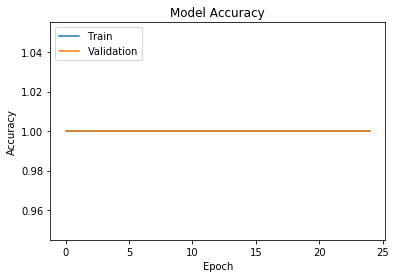

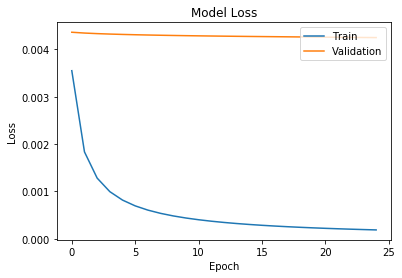

In [119]:
# Plot accuracy
plt.plot(malstm_trained.history['acc'])
plt.plot(malstm_trained.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot loss
plt.plot(malstm_trained.history['loss'])
plt.plot(malstm_trained.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [121]:
# evaluate the model
scores = malstm.evaluate([X_test['left'], X_test['right']], Y_test, verbose=0)
print("%s: %.2f%%" % (malstm.metrics_names[1], scores[1]*100))

acc: 100.00%
